# Student Test Scores — Fixed & Optimised Ensemble

## What was wrong before (and what this notebook fixes)

| # | Bug | Fix |
|---|-----|-----|
| 1 | `GridSearchCV` trained on stale `X` (Cell 10), **missing all engineered features** | Feature-engineer → encode → split → train, in that order |
| 2 | `internet_access`, `facility_rating`, `exam_difficulty` never encoded | Encode every categorical column |
| 3 | Optimisation metric was MAE, competition metric is **RMSE** | Use `neg_root_mean_squared_error` everywhere |
| 4 | `age_group` bins were arbitrary and inconsistent between notebooks | Data-driven quantile bins |
| 5 | Train and test encoded separately → column mismatch | Concat → encode → split back |

**Current leaderboard scores:**
| Submission | Public RMSE |
|---|---|
| Submission 1 (single LGB) | 8.73744 |
| Submission 2 (Optuna LGB) | 8.72869 |
| Submission 3 (ensemble) | 8.72075 |
| **Top 5** | **8.533–8.538** |
| **Gap to close** | **≈ 0.19** |


## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
SEED = 42
np.random.seed(SEED)
print("✓ imports done")

✓ imports done


## 2. Load data

In [2]:
train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')

print(f"train {train.shape}   test {test.shape}")
print("\ncolumns:", train.columns.tolist())
print("\ntarget stats:\n", train['exam_score'].describe())

train (630000, 13)   test (270000, 12)

columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']

target stats:
 count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64


## 3. Quick EDA — understand the features before engineering them

gender: 3 unique → {'other': 211097, 'male': 210593, 'female': 208310}
course: 7 unique → {'b.tech': 131236, 'b.sc': 111554, 'b.com': 110932, 'bca': 88721, 'bba': 75644, 'ba': 61989, 'diploma': 49924}
internet_access: 2 unique → {'yes': 579423, 'no': 50577}
sleep_quality: 3 unique → {'poor': 213675, 'good': 213089, 'average': 203236}
study_method: 5 unique → {'coaching': 131697, 'self-study': 131131, 'mixed': 123086, 'group study': 123009, 'online videos': 121077}
facility_rating: 3 unique → {'medium': 214082, 'low': 212378, 'high': 203540}
exam_difficulty: 3 unique → {'moderate': 353982, 'easy': 176540, 'hard': 99478}


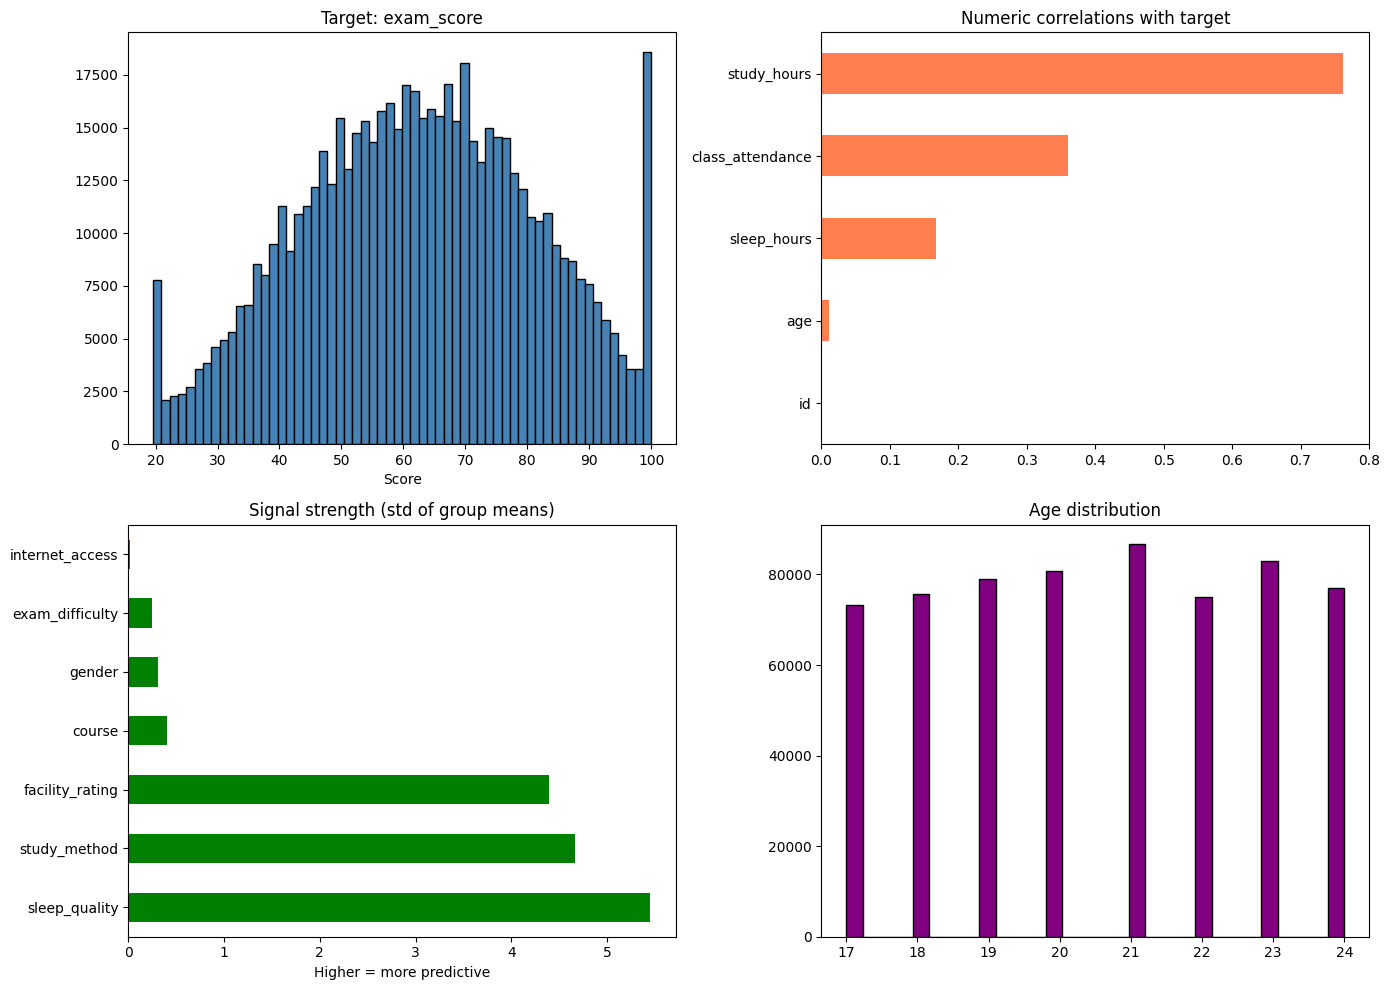

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# target distribution
axes[0,0].hist(train['exam_score'], bins=60, color='steelblue', edgecolor='black')
axes[0,0].set_title('Target: exam_score')
axes[0,0].set_xlabel('Score')

# numeric correlations with target
num_cols = train.select_dtypes(include='number').columns.tolist()
corr = train[num_cols].corr()['exam_score'].drop('exam_score').sort_values()
corr.plot(kind='barh', ax=axes[0,1], color='coral')
axes[0,1].set_title('Numeric correlations with target')

# categorical value counts
cat_cols = ['gender','course','internet_access','sleep_quality',
            'study_method','facility_rating','exam_difficulty']
for col in cat_cols:
    print(f"{col}: {train[col].nunique()} unique →", train[col].value_counts().to_dict())

# mean target by each categorical (shows which have signal)
means = {}
for col in cat_cols:
    means[col] = train.groupby(col)['exam_score'].mean().std()  # std of group means = signal strength
signal = pd.Series(means).sort_values(ascending=False)
signal.plot(kind='barh', ax=axes[1,0], color='green')
axes[1,0].set_title('Signal strength (std of group means)')
axes[1,0].set_xlabel('Higher = more predictive')

# age distribution
axes[1,1].hist(train['age'], bins=30, color='purple', edgecolor='black')
axes[1,1].set_title('Age distribution')

plt.tight_layout()
plt.show()

## 4. Feature engineering

Rules:
- **All** transformations go inside one function applied identically to train & test.
- Categorical binning uses **data-driven** quantile cuts so they generalise.
- We keep the raw features too — the tree models decide what to use.

In [4]:
def engineer(df):
    """Deterministic feature engineering — call on train and test alike."""
    df = df.copy()

    # ── numeric interactions & polynomials ──
    df['study_hours_sq']        = df['study_hours'] ** 2
    df['sleep_hours_sq']        = df['sleep_hours'] ** 2
    df['attendance_sq']         = df['class_attendance'] ** 2
    df['study_x_attendance']    = df['study_hours'] * df['class_attendance']
    df['study_sleep_ratio']     = df['study_hours'] / (df['sleep_hours'] + 1e-6)
    df['age_x_study']           = df['age'] * df['study_hours']
    df['attendance_x_sleep']    = df['class_attendance'] * df['sleep_hours']
    df['study_x_sleep']         = df['study_hours'] * df['sleep_hours']
    df['total_hours']           = df['study_hours'] + df['sleep_hours']
    df['study_frac']            = df['study_hours'] / (df['total_hours'] + 1e-6)

    # ── quantile-based bins (edges fixed from TRAIN, applied to both) ──
    # We pass edges explicitly so test uses the same boundaries
    df['age_bin']      = pd.cut(df['age'],           bins=AGE_EDGES,      labels=False, include_lowest=True)
    df['study_bin']    = pd.cut(df['study_hours'],   bins=STUDY_EDGES,    labels=False, include_lowest=True)
    df['sleep_bin']    = pd.cut(df['sleep_hours'],   bins=SLEEP_EDGES,    labels=False, include_lowest=True)
    df['attend_bin']   = pd.cut(df['class_attendance'], bins=ATTEND_EDGES, labels=False, include_lowest=True)

    return df

# Compute bin edges from TRAIN only (to avoid leakage)
def quantile_edges(series, n=4):
    edges = series.quantile(np.linspace(0, 1, n + 1)).values
    edges[0]  = -np.inf   # catch anything below
    edges[-1] =  np.inf   # catch anything above
    return edges

AGE_EDGES     = quantile_edges(train['age'])
STUDY_EDGES   = quantile_edges(train['study_hours'])
SLEEP_EDGES   = quantile_edges(train['sleep_hours'])
ATTEND_EDGES  = quantile_edges(train['class_attendance'])

print("Bin edges (train-derived):")
print(f"  age:        {AGE_EDGES}")
print(f"  study_hrs:  {STUDY_EDGES}")
print(f"  sleep_hrs:  {SLEEP_EDGES}")
print(f"  attendance: {ATTEND_EDGES}")


Bin edges (train-derived):
  age:        [-inf  19.  21.  23.  inf]
  study_hrs:  [-inf 1.97 4.   6.05  inf]
  sleep_hrs:  [-inf  5.6  7.1  8.6  inf]
  attendance: [-inf 57.  72.6 87.2  inf]


## 5. Prepare train & test — engineer → encode → align

**Key:** we concat train + test *before* `get_dummies` so every dummy column exists in both.

In [5]:
# Separate target and ids
y_train  = train['exam_score']
X_train  = train.drop(columns=['id', 'exam_score'])
X_test   = test.drop(columns=['id'])
test_ids = test['id']

# Engineer
X_train = engineer(X_train)
X_test  = engineer(X_test)

# ── encode together ──
combined         = pd.concat([X_train, X_test], keys=['train','test'])
combined_encoded = pd.get_dummies(combined, drop_first=True)

X_train_enc = combined_encoded.loc['train'].reset_index(drop=True)
X_test_enc  = combined_encoded.loc['test'].reset_index(drop=True)

# sanity checks
assert X_train_enc.shape[1] == X_test_enc.shape[1], "column count mismatch!"
assert X_train_enc.isnull().sum().sum() == 0, "NaN in train!"
assert X_test_enc.isnull().sum().sum() == 0,  "NaN in test!"

print(f"✓ train {X_train_enc.shape}   test {X_test_enc.shape}")
print(f"  {X_train_enc.shape[1]} features total")
print(f"\nFeatures:\n{X_train_enc.columns.tolist()}")

✓ train (630000, 37)   test (270000, 37)
  37 features total

Features:
['age', 'study_hours', 'class_attendance', 'sleep_hours', 'study_hours_sq', 'sleep_hours_sq', 'attendance_sq', 'study_x_attendance', 'study_sleep_ratio', 'age_x_study', 'attendance_x_sleep', 'study_x_sleep', 'total_hours', 'study_frac', 'age_bin', 'study_bin', 'sleep_bin', 'attend_bin', 'gender_male', 'gender_other', 'course_b.sc', 'course_b.tech', 'course_ba', 'course_bba', 'course_bca', 'course_diploma', 'internet_access_yes', 'sleep_quality_good', 'sleep_quality_poor', 'study_method_group study', 'study_method_mixed', 'study_method_online videos', 'study_method_self-study', 'facility_rating_low', 'facility_rating_medium', 'exam_difficulty_hard', 'exam_difficulty_moderate']


## 6. 5-fold cross-validation helper

Using CV instead of a single train/val split gives a much more reliable
estimate and prevents us from over-fitting to one particular split.

In [6]:
KF = KFold(n_splits=5, shuffle=True, random_state=SEED)

def cv_rmse(model_class, params, X, y):
    """Return mean CV RMSE for a given model + params."""
    scores = []
    for tr_idx, val_idx in KF.split(X):
        m = model_class(**params)
        m.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        pred = m.predict(X.iloc[val_idx])
        scores.append(np.sqrt(mean_squared_error(y.iloc[val_idx], pred)))
    return np.mean(scores), np.std(scores)

print("✓ CV helper ready (5-fold)")

✓ CV helper ready (5-fold)


## 7. Optuna — LightGBM (100 trials, 5-fold CV, RMSE metric)

In [ ]:
def lgb_objective(trial):
    params = dict(
        objective      = 'regression',
        metric         = 'rmse',          # ← RMSE, not MAE
        verbosity      = -1,
        random_state   = SEED,
        n_estimators   = trial.suggest_int('n_estimators', 200, 1000),
        learning_rate  = trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        max_depth      = trial.suggest_int('max_depth', 4, 14),
        num_leaves     = trial.suggest_int('num_leaves', 24, 200),
        min_child_samples = trial.suggest_int('min_child_samples', 10, 100),
        subsample      = trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0),
        reg_alpha      = trial.suggest_float('reg_alpha', 1e-6, 5.0, log=True),
        reg_lambda     = trial.suggest_float('reg_lambda', 1e-6, 5.0, log=True),
    )
    rmse, _ = cv_rmse(lgb.LGBMRegressor, params, X_train_enc, y_train)
    return rmse

lgb_study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
print("Running LightGBM optimisation (100 trials × 5 folds)…")
lgb_study.optimize(lgb_objective, n_trials=40, show_progress_bar=True)
print(f"\n✓ LightGBM  best CV RMSE: {lgb_study.best_value:.5f}")
print(f"  params: {lgb_study.best_params}")

Running LightGBM optimisation (100 trials × 5 folds)…


  0%|          | 0/40 [00:00<?, ?it/s]

## 8. Optuna — XGBoost (100 trials, 5-fold CV)

In [ ]:
def xgb_objective(trial):
    params = dict(
        objective      = 'reg:squarederror',
        eval_metric    = 'rmse',
        random_state   = SEED,
        verbosity      = 0,
        n_estimators   = trial.suggest_int('n_estimators', 200, 1000),
        learning_rate  = trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        max_depth      = trial.suggest_int('max_depth', 4, 14),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        subsample      = trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0),
        gamma          = trial.suggest_float('gamma', 1e-6, 1.0, log=True),
        reg_alpha      = trial.suggest_float('reg_alpha', 1e-6, 5.0, log=True),
        reg_lambda     = trial.suggest_float('reg_lambda', 1e-6, 5.0, log=True),
    )
    rmse, _ = cv_rmse(xgb.XGBRegressor, params, X_train_enc, y_train)
    return rmse

xgb_study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
print("Running XGBoost optimisation (100 trials × 5 folds)…")
xgb_study.optimize(xgb_objective, n_trials=100, show_progress_bar=True)
print(f"\n✓ XGBoost   best CV RMSE: {xgb_study.best_value:.5f}")
print(f"  params: {xgb_study.best_params}")

## 9. Optuna — CatBoost (100 trials, 5-fold CV)

In [ ]:
def cat_objective(trial):
    params = dict(
        loss_function  = 'RMSE',
        random_seed    = SEED,
        verbose        = 0,
        iterations     = trial.suggest_int('iterations', 200, 1000),
        learning_rate  = trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        depth          = trial.suggest_int('depth', 4, 12),
        l2_leaf_reg    = trial.suggest_float('l2_leaf_reg', 1e-6, 5.0, log=True),
        subsample      = trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 100),
    )
    rmse, _ = cv_rmse(CatBoostRegressor, params, X_train_enc, y_train)
    return rmse

cat_study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
print("Running CatBoost optimisation (100 trials × 5 folds)…")
cat_study.optimize(cat_objective, n_trials=100, show_progress_bar=True)
print(f"\n✓ CatBoost  best CV RMSE: {cat_study.best_value:.5f}")
print(f"  params: {cat_study.best_params}")

## 10. Out-of-fold predictions → optimise blend weights

Instead of a single train/val split we collect **out-of-fold (OOF)** predictions
for every row in the training set. This gives an unbiased estimate of each
model's predictions and lets us find the best blend weights reliably.

In [ ]:
def oof_predict(model_class, params, X, y, X_test):
    """Return OOF predictions on X and averaged test predictions."""
    oof  = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))

    for tr_idx, val_idx in KF.split(X):
        m = model_class(**params)
        m.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        oof[val_idx]  = m.predict(X.iloc[val_idx])
        test_preds   += m.predict(X_test) / KF.get_n_splits()

    return oof, test_preds

print("Generating OOF + test predictions for each model…\n")

lgb_oof, lgb_test = oof_predict(lgb.LGBMRegressor,
    {**lgb_study.best_params, 'verbosity': -1, 'random_state': SEED},
    X_train_enc, y_train, X_test_enc)
print(f"  LGB OOF RMSE: {np.sqrt(mean_squared_error(y_train, lgb_oof)):.5f}")

xgb_oof, xgb_test = oof_predict(xgb.XGBRegressor,
    {**xgb_study.best_params, 'verbosity': 0, 'random_state': SEED},
    X_train_enc, y_train, X_test_enc)
print(f"  XGB OOF RMSE: {np.sqrt(mean_squared_error(y_train, xgb_oof)):.5f}")

cat_oof, cat_test = oof_predict(CatBoostRegressor,
    {**cat_study.best_params, 'verbose': 0, 'random_seed': SEED},
    X_train_enc, y_train, X_test_enc)
print(f"  CAT OOF RMSE: {np.sqrt(mean_squared_error(y_train, cat_oof)):.5f}")


## 11. Optimise blend weights on OOF predictions

In [ ]:
def blend_objective(trial):
    w_lgb = trial.suggest_float('w_lgb', 0.0, 1.0)
    w_xgb = trial.suggest_float('w_xgb', 0.0, 1.0)
    w_cat = trial.suggest_float('w_cat', 0.0, 1.0)
    s = w_lgb + w_xgb + w_cat
    w_lgb, w_xgb, w_cat = w_lgb/s, w_xgb/s, w_cat/s

    blend = w_lgb * lgb_oof + w_xgb * xgb_oof + w_cat * cat_oof
    return np.sqrt(mean_squared_error(y_train, blend))

blend_study = optuna.create_study(direction='minimize')
blend_study.optimize(blend_objective, n_trials=200)

raw = blend_study.best_params
s   = sum(raw.values())
W   = {k: v/s for k, v in raw.items()}

print(f"\n✓ Optimal blend weights:")
print(f"    LightGBM : {W['w_lgb']:.3f}")
print(f"    XGBoost  : {W['w_xgb']:.3f}")
print(f"    CatBoost : {W['w_cat']:.3f}")
print(f"  Blend OOF RMSE: {blend_study.best_value:.5f}")
print(f"\n  vs best single model OOF RMSE: {min(np.sqrt(mean_squared_error(y_train, lgb_oof)), np.sqrt(mean_squared_error(y_train, xgb_oof)), np.sqrt(mean_squared_error(y_train, cat_oof))):.5f}")

## 12. Generate submission

In [ ]:
# Blend test predictions with optimised weights
final_pred = W['w_lgb'] * lgb_test + W['w_xgb'] * xgb_test + W['w_cat'] * cat_test

# Clip to valid range (exam scores are 0-100)
final_pred = np.clip(final_pred, 0, 100)

submission = pd.DataFrame({'id': test_ids, 'exam_score': final_pred})
submission.to_csv('submission_v4.csv', index=False)

print("="*60)
print("SUBMISSION READY: submission_v4.csv")
print("="*60)
print(f"\nRows: {len(submission)}")
print(f"Pred range: [{final_pred.min():.2f}, {final_pred.max():.2f}]")
print(f"Pred mean:  {final_pred.mean():.2f}")
print(f"\nOOF RMSE estimates:")
print(f"  LightGBM : {np.sqrt(mean_squared_error(y_train, lgb_oof)):.5f}")
print(f"  XGBoost  : {np.sqrt(mean_squared_error(y_train, xgb_oof)):.5f}")
print(f"  CatBoost : {np.sqrt(mean_squared_error(y_train, cat_oof)):.5f}")
print(f"  Blend    : {blend_study.best_value:.5f}")
print("\n" + submission.head(10).to_string(index=False))

## 13. Feature importance (averaged across folds)

In [ ]:
# Train one LGB on full data just to visualise importances
lgb_full = lgb.LGBMRegressor(**lgb_study.best_params, verbosity=-1, random_state=SEED)
lgb_full.fit(X_train_enc, y_train)

imp = pd.DataFrame({'feature': X_train_enc.columns,
                     'importance': lgb_full.feature_importances_}
                   ).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(imp['feature'][:20][::-1], imp['importance'][:20][::-1], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.tight_layout()
plt.show()

print(imp.to_string(index=False))